# Record Disambiguation

In this notebook we perform entity disambiguation on records, specifically person records.

In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from tqdm.auto import tqdm

import sys
sys.path.append("..")

from heritageconnector.disambiguation.helpers import load_training_data, plot_performance_curves
from heritageconnector.disambiguation.pipelines import Disambiguator
from heritageconnector.disambiguation.postprocessing import filter_cased_wikidata_labels, remove_wikidata_items_with_no_claims
from heritageconnector.utils.wikidata import get_sparql_results, url_to_qid
from heritageconnector.utils.generic import paginate_list
from heritageconnector.config import config

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data
This data has already been generated using `Disambiguator.save_training_data_to_folder` and `Disambiguator.save_test_data_to_folder`.

In [48]:
train_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/train/"
# test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/test_computing_space/"
test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/test_photographic_aeronautics/"
# test_dir = "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/test_art_locomotives_and_rolling_stock/"

In [3]:
X, y, pairs, pids = load_training_data(train_dir)
X_new, pairs_new, pids_new = load_training_data(test_dir)

In [4]:
pairs['y'] = y
len(pairs[pairs['y'] == True])

20

In [5]:
pids, pids_new

(['P580', 'P186', 'P176', 'label', 'P31'],
 ['P580', 'P186', 'P176', 'label', 'P31'])

In [6]:
X.shape, X_new.shape

((720, 5), (21163, 5))

In [7]:
X.sum(axis=0), X_new.sum(axis=0)

(array([ 19.52435859,   4.51999998,   1.        , 525.39000006,
         49.06818718]),
 array([  522.29956887,   112.39000048,     0.        , 15048.49998747,
         1331.9364215 ]))

In [8]:
pairs.head()

,internal_id,wikidata_id,is_type,y
0,https://collection.sciencemuseumgroup.org.uk/objects/co205781,Q60692892,True,False
1,https://collection.sciencemuseumgroup.org.uk/objects/co205781,Q7904269,False,False
2,https://collection.sciencemuseumgroup.org.uk/objects/co205781,Q912552,True,False
3,https://collection.sciencemuseumgroup.org.uk/objects/co205781,Q171043,True,False
4,https://collection.sciencemuseumgroup.org.uk/objects/co205781,Q23461745,False,False


## 2. Train classifier
The disambiguator wraps `sklearn.tree.DecisionTreeClassifier` and takes its parameters as inputs.

### 2a. Test classifier performance
We'll perform a train/test split on the labelled data to quickly test the classifier's performance using its `score` method. 

The `score` method here returns [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html): accuracy weighted so that each class is considered evenly.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, random_state=42, test_size=0.2, stratify=y)
len(X_train), len(X_test)

(576, 144)

In [10]:
train_idx = X_train.index.tolist()
test_idx = X_test.index.tolist()

pairs_train = pairs.loc[train_idx, :]
pairs_test = pairs.loc[test_idx, :]

len(X_train), len(pairs_train), len(X_test), len(pairs_test)

(576, 576, 144, 144)

In [11]:
clf = Disambiguator('OBJECT', max_depth=None).fit(X_train, y_train)
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    print(str(threshold) + " --- \n" + clf.score(X_test, y_test, threshold))

0.5 --- 
balanced accuracy score: 0.8821428571428571
precision score: 0.10810810810810811
recall score: 1.0
0.6 --- 
balanced accuracy score: 0.8821428571428571
precision score: 0.10810810810810811
recall score: 1.0
0.7 --- 
balanced accuracy score: 0.8535714285714286
precision score: 0.3333333333333333
recall score: 0.75
0.8 --- 
balanced accuracy score: 0.8642857142857143
precision score: 0.5
recall score: 0.75
0.9 --- 
balanced accuracy score: 0.8642857142857143
precision score: 0.5
recall score: 0.75
0.95 --- 
balanced accuracy score: 0.8642857142857143
precision score: 0.5
recall score: 0.75


In [18]:
pairs_predicted = clf.get_predictions_table(X_test, pairs_test, threshold=0.8)

pairs_predicted_filtered = filter_cased_wikidata_labels(pairs_predicted)
pairs_predicted_filtered = remove_wikidata_items_with_no_claims(pairs_predicted_filtered)

y_filtered = pairs_predicted_filtered['y'].tolist()
y_pred_filtered = pairs_predicted_filtered['y_pred'].tolist()

precision_score(y_filtered, y_pred_filtered), recall_score(y_filtered, y_pred_filtered), balanced_accuracy_score(y_filtered, y_pred_filtered)

(0.6, 0.75, 0.8662280701754386)

### 2b. Analyse classifier results

In [24]:
y_pred = clf.predict(X_test, threshold=0.8)

TPs = np.where((y_pred==True) & (y_test==True))
FPs = np.where((y_pred==True) & (y_test==False))
FNs = np.where((y_pred==False) & (y_test==True))
TNs = np.where((y_pred==False) & (y_test==False))

print(len(TPs[0]), len(FPs[0]), len(TNs[0]), len(FNs[0]))

3 3 137 1


In [25]:
pairs_test.iloc[FPs]

,internal_id,wikidata_id,is_type,y
192,https://collection.sciencemuseumgroup.org.uk/objects/co8414844,Q193692,True,False
680,https://collection.sciencemuseumgroup.org.uk/objects/co63962,Q80031078,True,False
280,https://collection.sciencemuseumgroup.org.uk/objects/co8232360,Q4045099,True,False


In [26]:
X_test.iloc[FPs]

,0,1,2,3,4
192,0.0,0.0,0.0,1.0,1.000000
680,0.0,0.0,0.0,1.0,0.500000
280,0.0,0.0,0.0,1.0,0.333333


### 2c. Use classifier to predict new Wikidata links

In [40]:
clf = Disambiguator('OBJECT').fit(X, y)
y_pred = clf.predict(X_new, threshold=0.9)
y_pred_proba = clf.predict_proba(X_new)

print(f"{np.unique(y_pred, return_counts=True)[1][1]} potential new links found")

702 potential new links found


In [41]:
pairs_new = clf.get_predictions_table(X_new, pairs_new, threshold=0.9)

The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches.

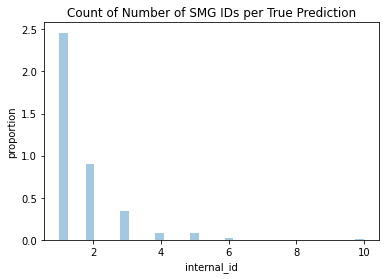

In [42]:
display(Markdown("The graph below shows the distribution of the number of predicted matches per SMG ID. Around 75% have a unique match, and most of the remainder have two matches."))
sns.distplot(pairs_new.loc[pairs_new["y_pred"] == True, "internal_id"].value_counts(), kde=False, norm_hist=True).set_ylabel('proportion')
plt.gca().set_title('Count of Number of SMG IDs per True Prediction');

In [43]:
pairs_new.sort_values('y_pred_proba', ascending=False).head(10)

,internal_id,wikidata_id,is_type,y_pred_proba,y_pred
854,https://collection.sciencemuseumgroup.org.uk/objects/co62801,Q4389389,True,0.972222,True
6635,https://collection.sciencemuseumgroup.org.uk/objects/co64136,Q54854916,True,0.972222,True
11843,https://collection.sciencemuseumgroup.org.uk/objects/co526480,Q1578699,True,0.972222,True
11841,https://collection.sciencemuseumgroup.org.uk/objects/co526480,Q371482,True,0.972222,True
18288,https://collection.sciencemuseumgroup.org.uk/objects/co39987,Q59103,True,0.972222,True
3781,https://collection.sciencemuseumgroup.org.uk/objects/co8399490,Q1053749,True,0.972222,True
3110,https://collection.sciencemuseumgroup.org.uk/objects/co8640272,Q2933722,True,0.972222,True
15085,https://collection.sciencemuseumgroup.org.uk/objects/co63986,Q1327833,True,0.972222,True
4212,https://collection.sciencemuseumgroup.org.uk/objects/co523254,Q12047070,True,0.972222,True
20220,https://collection.sciencemuseumgroup.org.uk/objects/co39986,Q59131,True,0.972222,True


## 2d. Filter matches

In [44]:
pairs_true = pairs_new[pairs_new['y_pred'] == True]
print(len(pairs_true))

pairs_true_filtered = filter_cased_wikidata_labels(pairs_true)
pairs_true_filtered = remove_wikidata_items_with_no_claims(pairs_true_filtered)
pairs_true_filtered = filter_max_wikidata_links(pairs_true_filtered, 2)

print("-- After Filtering --")
print(f"No. new links: {len(pairs_true_filtered)}")
print(f"No. SMG items with new links: {len(pairs_true_filtered['internal_id'].unique())}")


702



-- After Filtering --
No. new links: 213
No. SMG items with new links: 172


## 3. Explain classifier
We can see that the classifier prioritises P569/P570 (birth and death dates), P21 (gender), label similarity, and occupation.

It's interesting to note that P31 (instance of), which tells the classifier whether the Wikidata record is a human, is not used. This is likely because P569/P570/P106/P21 are qualities which only humans can have.

P31 is likely to be much more prevalent when classifying objects, and distinguishing between e.g. paintings and posters.

In [45]:
clf.print_tree(feature_names=pids)

|--- label <= 0.97
|   |--- label <= 0.80
|   |   |--- class: False
|   |--- label >  0.80
|   |   |--- label <= 0.81
|   |   |   |--- class: True
|   |   |--- label >  0.81
|   |   |   |--- label <= 0.81
|   |   |   |   |--- class: False
|   |   |   |--- label >  0.81
|   |   |   |   |--- class: False
|--- label >  0.97
|   |--- P31 <= 0.13
|   |   |--- P31 <= 0.00
|   |   |   |--- class: True
|   |   |--- P31 >  0.00
|   |   |   |--- class: True
|   |--- P31 >  0.13
|   |   |--- P31 <= 0.75
|   |   |   |--- class: True
|   |   |--- P31 >  0.75
|   |   |   |--- class: True



## 4. Export model and final predictions

In [47]:
# clf.save_classifier_to_disk("/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/clf.pkl")
pairs_true_filtered.sort_values('y_pred_proba', ascending=False).to_csv(
    "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/computing_space_preds_positive.csv", index=False)

You can also use the below cell to export a sample of positive and negative samples to an Excel document for manual review